# Dynamic fitting of simulated diffusion weighted MRS.

This notebook demonstrates use of the FSL-MRS dynamic fitting tools.

The demonstration is performed on synthetic data made for the dwMRS workshop in Leiden in 2021. The data and basis set can be downloaded from [GitHub](https://github.com/dwmrshub/pregame-workshop-2021).

The notebook demonstrates:
1. How to generate the necessary configuration model file
2. Use the dynamic fitting tools in Python e.g. in an interactive notebook.
3. Run the identical analysis using the command line tools.

The same tools can be used for fMRS (and other things). An extensive [fMRS demo](https://github.com/wtclarke/fsl_mrs_fmrs_demo) is hosted online on Github.

## 1. Data load and exploration.
We will load the data to examine it and try fitting an average spectrum to assess the suitability of fitting options and the basis set.

In [6]:
# Define some data files for each spectrum
data_location = 'example_data/example_dwmrs/metab.nii.gz'
basis_location = 'example_data/example_dwmrs/basis'

Load the data and plot it.

In [31]:
from fsl_mrs.utils import mrs_io
from fsl_mrs.utils import plotting as splot

data = mrs_io.read_FID(data_location)
bvals = data.hdr_ext['dim_5_header']['Bval']
mrslist = data.mrs()

splot.plotly_dynMRS(mrslist, time_var=bvals, ppmlim=(0, 5))

The data looks like we expect; as b-value increases we see a decrease in the amplitude of the metabolites. You might notice three things:
1. There is a residual water peak at 4.65 ppm. That needs to be modelled in the basis set, and furthermore the rate of amplitude decrease is much higher compared to the metabolites.
2. There are macromolecules visible in the spectrum, but even at high b-values they are still present (and not that much smaller than at b=0).
3. The baseline varies with b-value.

We now want to see whether we can fit the data with the basis set we have. There's no point in continuing with the vastly more complex dynamic fit if we don't have a good description of the underlying metabolite signal to work with.

We will pick some spectral fitting options. These are a ppm range including the water peak (up to 5 ppm). A low order baseline as there is a predominantly flat baseline. A simple lineshape model (no Gaussian broadening). We separate the water and macromolecule (H20 & Mac) into their own groups as they are likely to need their own metabolite broadening parameters.

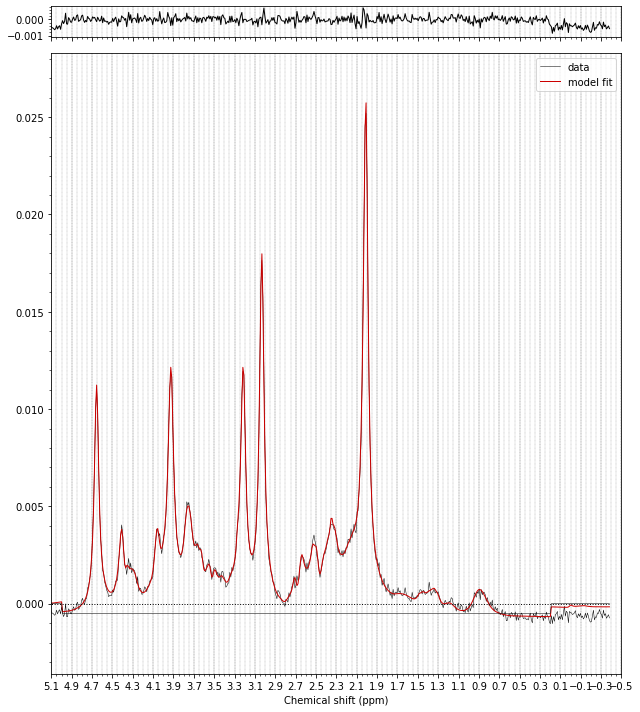

In [36]:
from fsl_mrs.utils.misc import parse_metab_groups
from fsl_mrs.utils import fitting

# select just the first (b value = 0) spectrum to test the fitting on
# this time the basis set is loaded alongside it.
mrs0 = data.mrs(basis_file=basis_location)[0]
# Check that the basis has the right phase/frequency convention
mrs0.check_Basis(repair=True)

# Select our fitting options
Fitargs = {'ppmlim': (0.2, 5.0),
           'baseline_order': 1,
           'metab_groups': parse_metab_groups(mrs0, ['H2O', 'Mac']),
           'model': 'lorentzian'}

# Run the fitting
res = fitting.fit_FSLModel(mrs0,**Fitargs)

# Plot the result
_ = splot.plot_fit(mrs0, res)

# 2. The dynamic model

Now we move on to the dynamic fitting part of this demo. We need to describe what our dynamic model is. We do this in a single python-formatted configuration file. In this configuration file we define:
1. The correspondence between spectra fitting parameters (known as _mapped_ parameters) and any dynamic model parameters we define (known as _free_ parameters).
2. Any bounds on the defined free parameters.
3. Any functional forms that the free parameters and time variable describe to constrain the multiple spectra.

We use the notebook 'magic' command %load to view what's in a preprepared config.py file

In [15]:
# %load example_data/example_dwmrs/config.py
# ------------------------------------------------------------------------
# User file for defining a model

# Parameter behaviour
# 'variable' : one per time point
# 'fixed'    : same for all time points
# 'dynamic'  : model-based change across time points

# Each parameter of the spectral fitting gets a specific behaviour
# The default behaviour is 'fixed'
Parameters = {
   'Phi_0'    : 'variable',
   'Phi_1'    : 'fixed',
   'conc'     : {'dynamic':'model_biexp','params':['c_amp','c_adc_slow','c_adc_fast','c_frac_slow']},
   'eps'      : 'fixed',
   'gamma'    : 'fixed',    
   'baseline' : {'dynamic':'model_exp_offset','params':['b_amp','b_adc','b_off']}
}

# Optionally define bounds on the parameters
Bounds = {
    'c_amp'       : (0,None),
    'c_adc_slow'  : (0,.1),
    'c_adc_fast'  : (.1,4),
    'c_frac_slow' : (0,1),
    'gamma'       : (0,None),
    'b_amp'       : (None,None),
    'b_adc'       : (1E-5,3),
    'b_off'       : (None,None)
}

# Dynamic models here
# These define how the parameters of the dynamic models change as a function 
# of the time variable (in dwMRS, that is the bvalue)
from numpy import exp
from numpy import asarray
from numpy import ones_like

# Mono-exponential model with offset
def model_exp_offset(p,t):
    # p = [amp,adc,off]
    return p[2]+p[0]*exp(-p[1]*t)

# Bi-exponential model
def model_biexp(p,t):
    # p = [amp,adc1,adc2,frac]
    return p[0]*(p[3]*exp(-p[1]*t)+(1-p[3])*exp(-p[2]*t))

# ------------------------------------------------------------------------
# Gradients
# For each of the models defined above, specify the gradient
# And call these functions using the same names as above with 
# '_grad' appended in the end
def model_biexp_grad(p,t):
    e1 = exp(-p[1]*t)
    e2 = exp(-p[2]*t)
    g0 = p[3]*e1+(1-p[3])*e2
    g1 = p[0]*(-p[3]*t*e1)
    g2 = p[0]*(-(1-p[3])*t*e2)
    g3 = p[0]*(e1-e2)
    return asarray([g0,g1,g2,g3])

def model_exp_offset_grad(p,t):
    e1 = exp(-p[1]*t)
    g0 = e1
    g1 = -t*p[0]*e1
    g2 = ones_like(t)
    return asarray([g0,g1,g2], dtype=object)


The above file come in three parts

#### Parameters variable (dict):
For each spectral fitting parameter type (e.g. concentration, or line-shift `eps`) this dict parameter defines whether that parameter:
- Takes a different (unconstrained) value for each b value - __variable__
- Has a fixed value across all b values - __fixed__
- Or is described by a function of the b value - __dynamic__

For the last of the options (dynamic), a function and any associated free parameters are defined. E.g. Metabolite concentrations (`conc`) follow a bi-exponential function (model_biexp) and therefore have four parameters associated with them (`'c_amp'`, `'c_adc_slow'`, `'c_adc_fast'`, `'c_frac_slow'`). Metabolite linewidths (`gamma`), however are fixed.

#### Bounds variable (dict):
This dictionary provides lower and upper bounds for free parameters. By default parameters are unconstrained, equivalent to `(None, None)`. But if you want to provide an upper or lower bound, or both bounds on parameters that is done using this interface. For instance the parameter `c_frac_slow` can only vary between 0 and 1.

#### Dynamic models and gradients (function definitions):
If a mapped parameter has been identified as `dynamic` then a functional relationship between the mapped parameter and the time variable and free parameters must be given.

These relationships are described using python functions. Each function listed in the `Parameters` dict must be defined. In addition a function providing the gradient of that function must be defined. E.g. `model_biexp` must be provided and so must `model_biexp_grad`.

# 3. Run the dynamic fitting.

We are now ready to run our dynamic fitting. This will use the data and basis set we loaded, the b values, the configuration file we inspected, and the spectral fitting options we selected.

In [48]:
import fsl_mrs.dynamic as dyn
import numpy as np

# ALl the data this time
mrslist = data.mrs(basis_file=basis_location)
# Check that the basis has the right phase/frequency convention
for mrs in mrslist:
    mrs.check_Basis(repair=True)

dobj = dyn.dynMRS(
        mrslist,
        bvals,
        config_file='example_data/example_dwmrs/config.py',
        rescale=True,
        **Fitargs)

dres = dobj.fit()

## 4. Results

First let's inspect the fits to judge the quality.

In [49]:
splot.plotly_dynMRS(mrslist, dres.reslist, dobj.time_var)

That looks reasonable. We can see how each mapped parameter looks across b values, compared to the results from the independent initialisation fits.

In the plot that will be generated the blue dots are the results from fitting each spectrum individually. The orange line is the mapped parameters (e.g. metabolite concentrations) extracted from the fitted free parameters. The orange line __is not__ a fit to the blue dots, but we would expect a close alignment for high SNR metabolites (e.g. NAA).

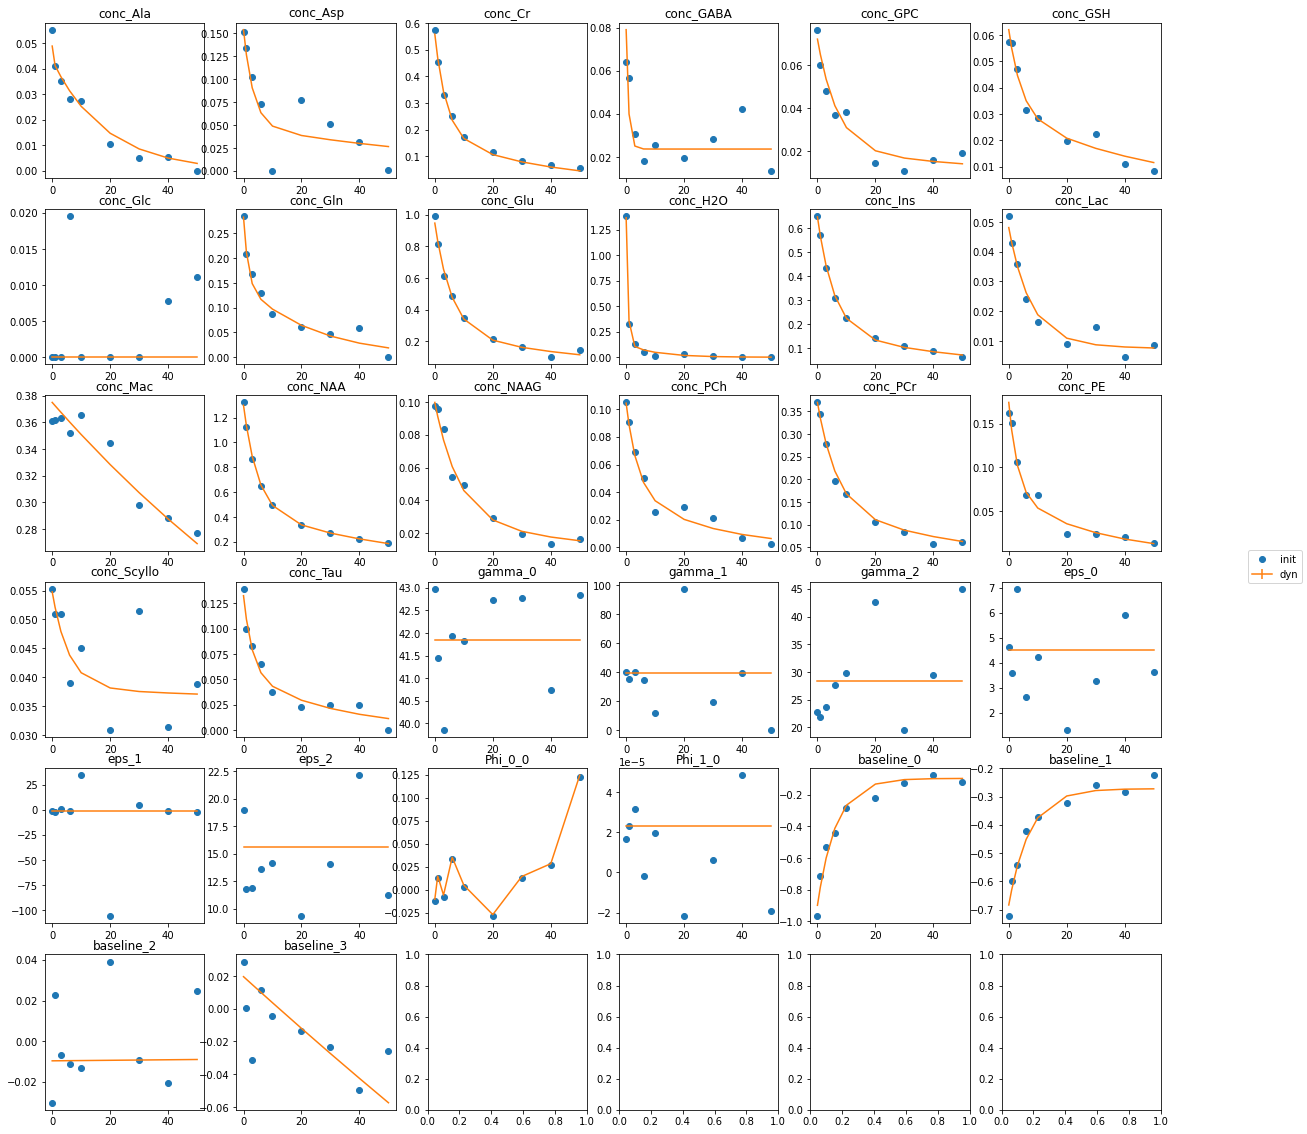

In [50]:
_ = dres.plot_mapped()

We can then also inspect the fitted free parameters, which for the concentrations are the desired outputs.

We can use some Pandas code to improve the look of this dataframe.

In [59]:
cres = dres.collected_results()
cres['conc'].style\
    .format(
        formatter={
            'c_amp': "{:0.3f}",
            'c_adc_slow': "{:0.3f}",
            'c_adc_fast': "{:0.2f}",
            'c_frac_slow': "{:0.2f}",})

,c_amp,c_adc_slow,c_adc_fast,c_frac_slow
metabolite,,,,
Ala,0.049,0.054,3.70,0.89
Asp,0.154,0.012,0.29,0.32
Cr,0.559,0.028,0.25,0.32
GABA,0.079,0.000,1.23,0.30
GPC,0.072,0.007,0.14,0.27
GSH,0.062,0.019,0.22,0.48
Glc,0.000,0.000,0.10,1.00
Gln,0.283,0.041,0.65,0.52
Glu,0.946,0.016,0.17,0.27


## A more complex model
It might not be appropriate to fit each metabolite with the same model. For instance a linear model for the macromolecules or a mon-exponential model for water might be more appropriate.

FSL-MRS can achieve this using the same framework.

In [63]:
mrslist = data.mrs(basis_file=basis_location)
# Check that the basis has the right phase/frequency convention
for mrs in mrslist:
    mrs.check_Basis(repair=True)

dobj2 = dyn.dynMRS(
        mrslist,
        bvals,
        config_file='example_data/example_dwmrs/config_multi.py',
        rescale=True,
        **Fitargs)

dres2 = dobj2.fit()

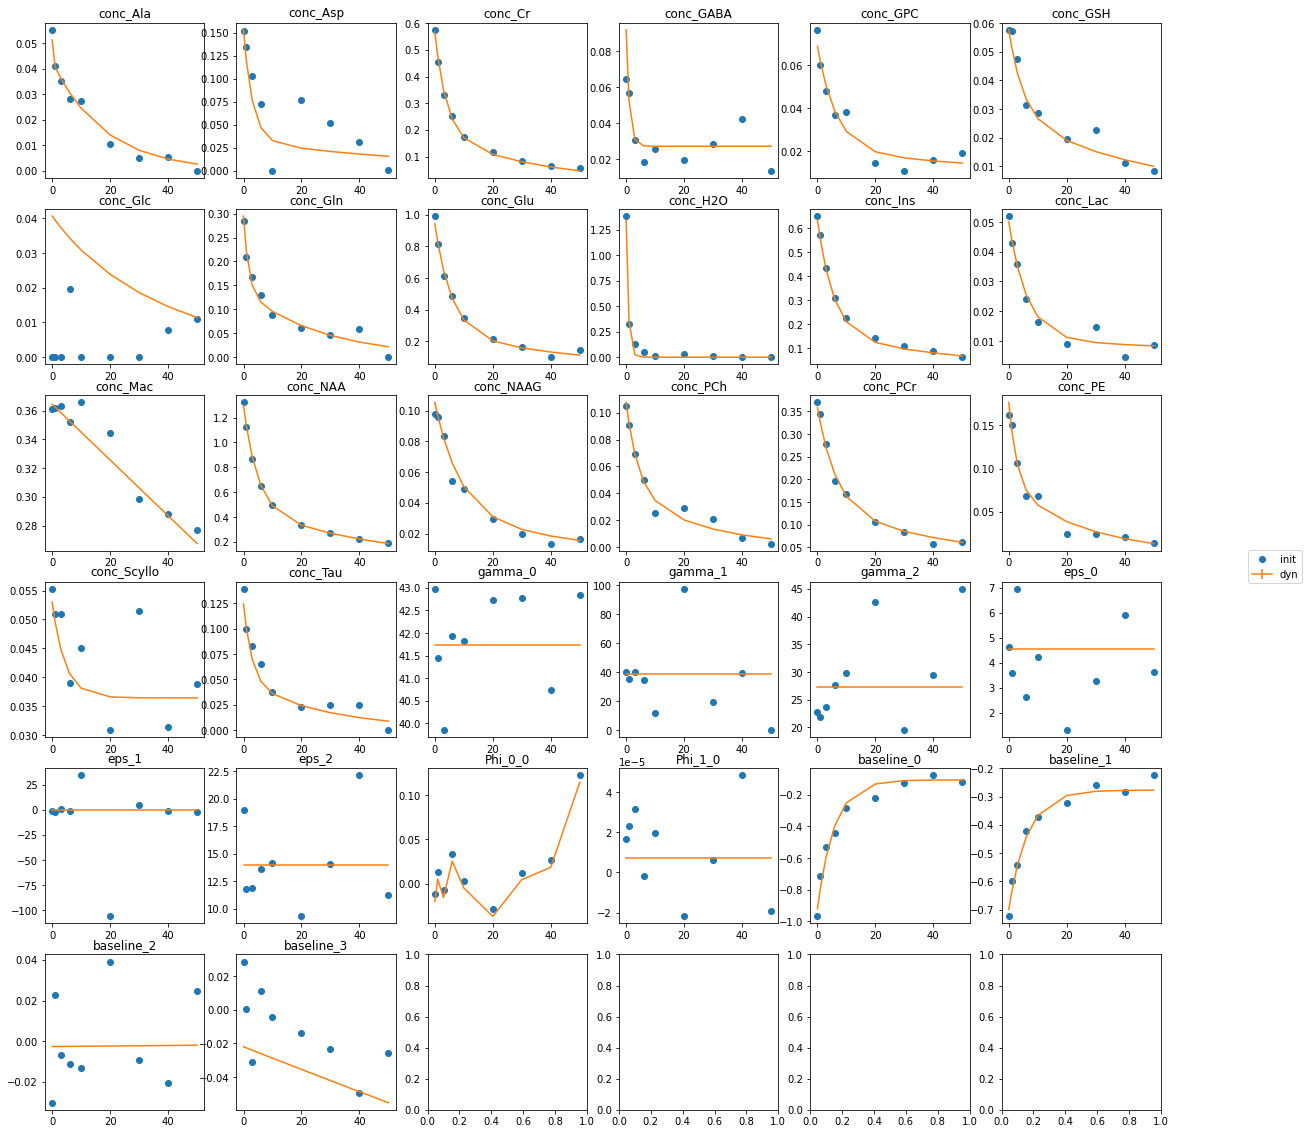

In [64]:
_ = dres2.plot_mapped()

In [65]:
cres2 = dres2.collected_results()
cres2['conc']

,c_amp,c_adc_slow,c_adc_fast,c_frac_slow,c_adc,c_slope
metabolite,,,,,,
Ala,0.051210,0.055734,3.701044,0.836475,NaN,NaN
Asp,0.153325,0.014590,0.326327,0.212901,NaN,NaN
Cr,0.566903,0.027343,0.249424,0.321872,NaN,NaN
GABA,0.091813,0.000000,0.943949,0.296047,NaN,NaN
GPC,0.068884,0.006307,0.153411,0.287418,NaN,NaN
GSH,0.057658,0.020483,0.202492,0.484120,NaN,NaN
Glc,0.040637,0.024023,0.100000,0.934087,NaN,NaN
Gln,0.294912,0.036766,0.581525,0.465804,NaN,NaN
Glu,0.941375,0.015845,0.173130,0.266299,NaN,NaN
